### Project 6

Détectez des faux billets \ Detect counterfeit notes

### libraries and data import

In [1]:
import pandas as pd
import numpy as np

import os

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from pandas.plotting import parallel_coordinates

from sklearn import preprocessing, decomposition, cluster
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# mise en place du dossier de travail
# setting up working directory
os.chdir(r"C:\Users\aciag\Desktop\IDF OpenClassrooms\P6_Mykhailytskyi_Mykola")
print("Current working directory is " + os.getcwd())

Current working directory is C:\Users\aciag\Desktop\IDF OpenClassrooms\P6_Mykhailytskyi_Mykola


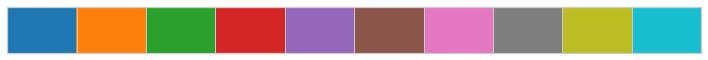

In [3]:
# color palette settings
plt.rcParams["figure.figsize"] = [7, 4]
plt.rcParams["figure.autolayout"] = True
sns.set_palette("tab10")
palette = sns.color_palette()
sns.palplot(palette)
plt.show();

In [4]:
# lire les données dans le dataframe de pandas
# read data into pandas dataframe

df = pd.read_csv(f'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/notes.csv')
df.sample(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
36,True,172.40,104.19,103.98,4.08,2.93,113.44
126,False,171.99,104.28,104.32,4.71,3.45,112.18
93,True,171.64,103.58,103.46,3.72,3.20,113.30
164,False,171.43,104.26,103.97,5.73,3.14,111.82
105,False,171.99,104.18,104.20,5.26,3.23,111.83


### Task 0, EDA

In [5]:
# Montant total des vrais et faux billets de banque
# total amount of real and fake banknotes
df.is_genuine.value_counts()

True     100
False     70
Name: is_genuine, dtype: int64

100 real banknotes and 70 fakes

In [6]:
# vérifier les valeurs manquantes
# check for missing values
print((df.isna().sum()/df.shape[0]*100).round(2))

is_genuine      0.0
diagonal        0.0
height_left     0.0
height_right    0.0
margin_low      0.0
margin_up       0.0
length          0.0
dtype: float64


No missing data in the dataset.

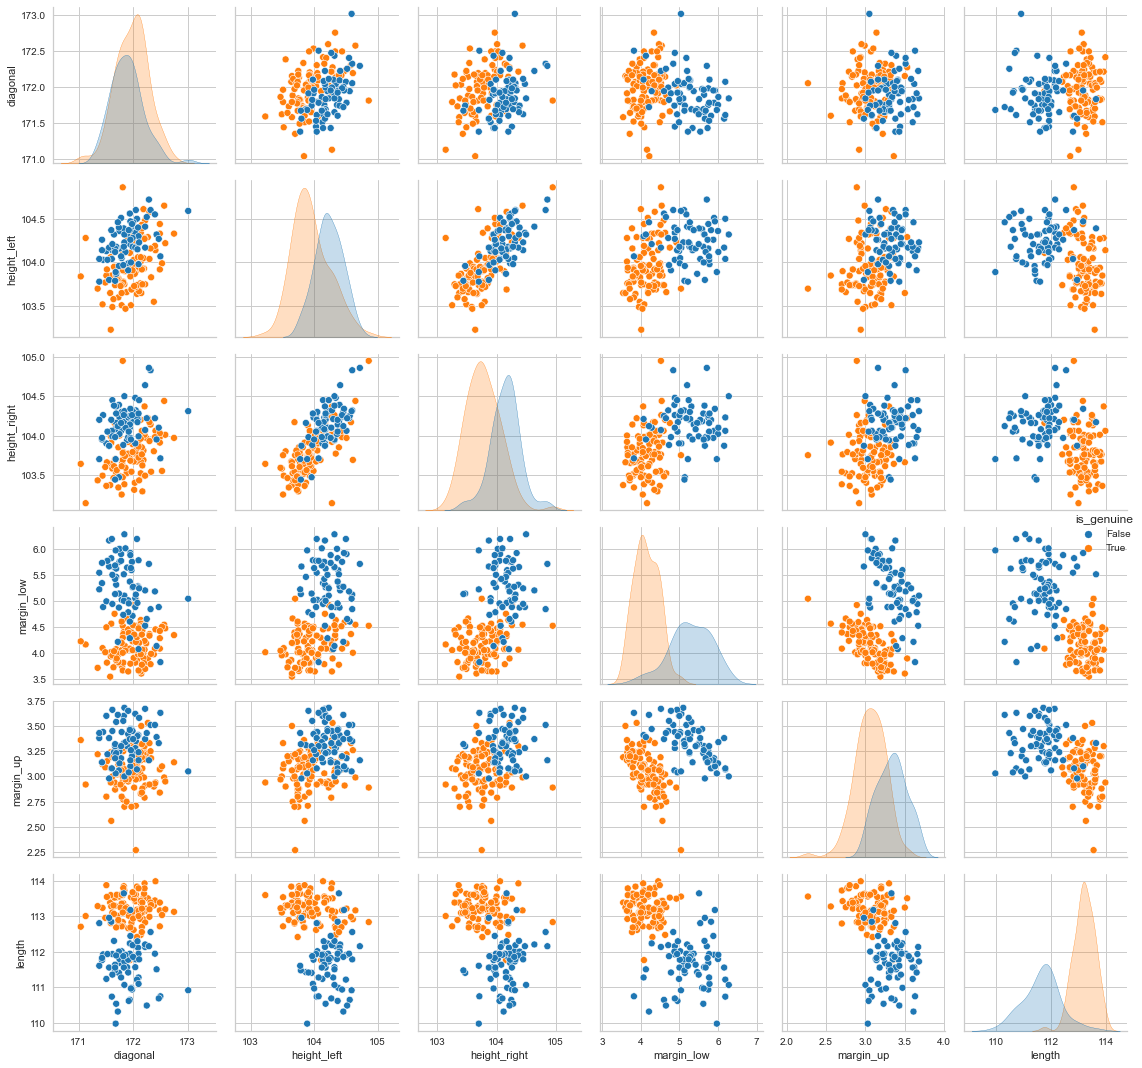

In [7]:
# Visualiser les relations dans l'ensemble de données
# visualize relationships in the dataset
sns.pairplot(df, kind='scatter', hue='is_genuine')
plt.savefig(fname='Variables_relationships.jpg', dpi=100, format='jpg', bbox_inches='tight')
plt.show();

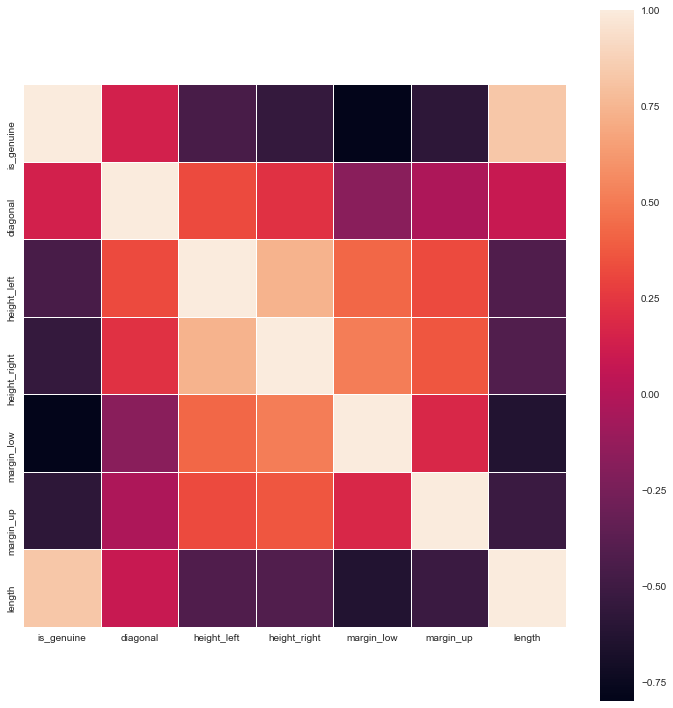

In [8]:
# visualiser les corrélations avec heatmap
# visualize correlations as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), linewidth=1, square=True)
plt.savefig(fname='Correlation_heatmap.jpg', dpi=100, format='jpg', bbox_inches='tight')
plt.show();

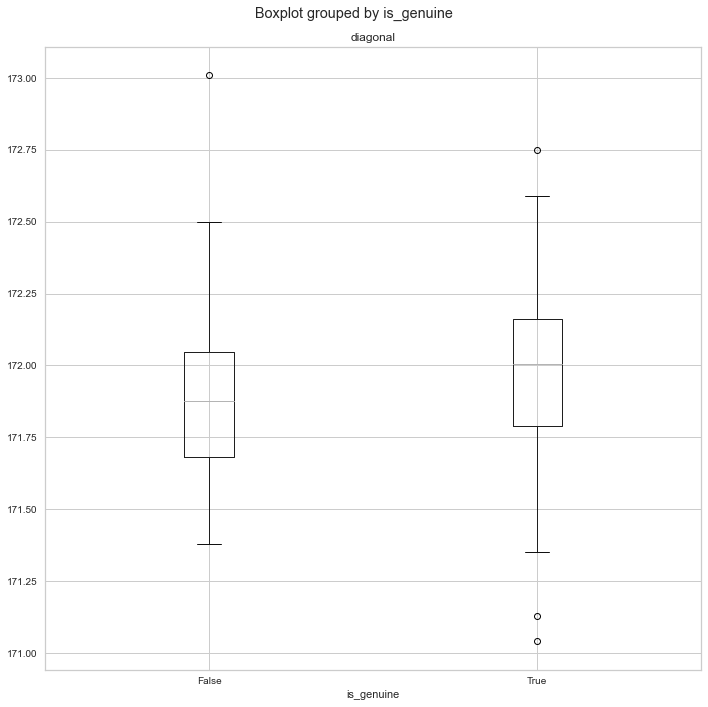

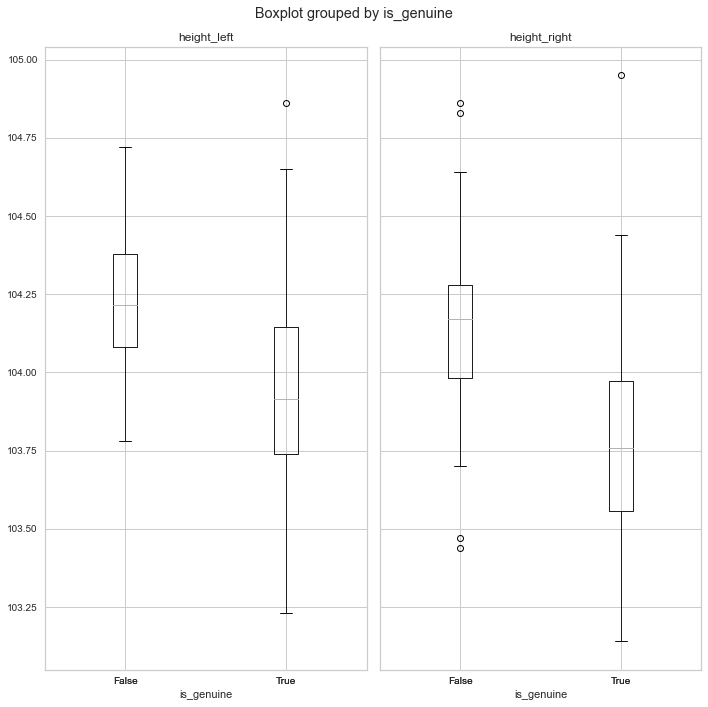

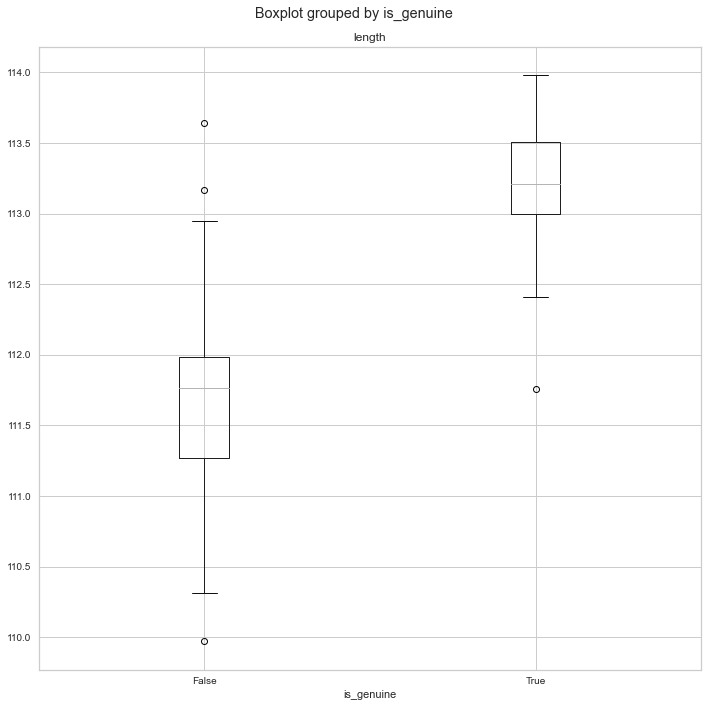

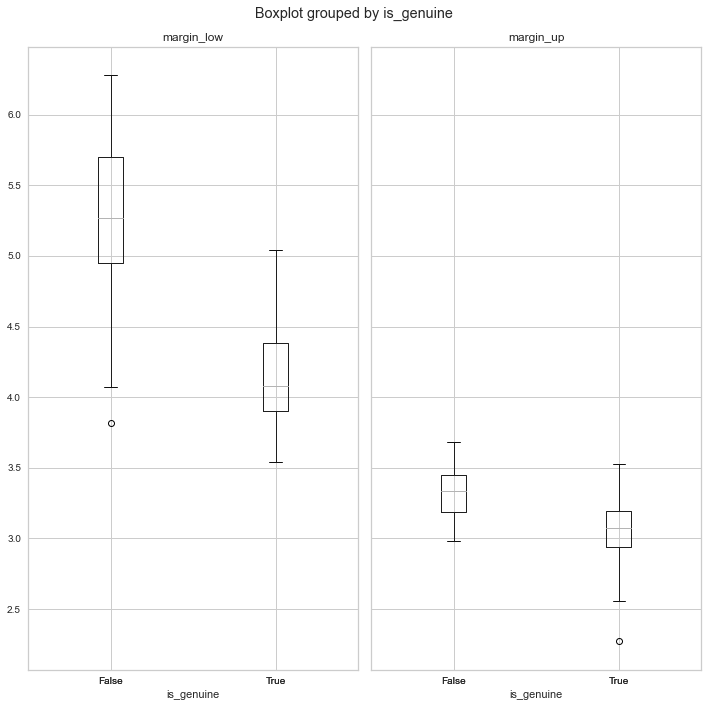

In [9]:
# visualiser les données variables réparties par type de billet de banque
# visualize variable data split by type of banknote
df.boxplot(column=['diagonal'], by='is_genuine', notch=False, figsize=(10,10))
plt.savefig(fname='Boxplot1.jpg', dpi=100, format='jpg', bbox_inches='tight')
plt.show();

df.boxplot(column=['height_left', 'height_right'], by='is_genuine', notch=False, figsize=(10,10))
plt.savefig(fname='Boxplot2.jpg', dpi=100, format='jpg', bbox_inches='tight')
plt.show();

df.boxplot(column=['length'], by='is_genuine', notch=False, figsize=(10,10))
plt.savefig(fname='Boxplot3.jpg', dpi=100, format='jpg', bbox_inches='tight')
plt.show();

df.boxplot(column=['margin_low', 'margin_up'], by='is_genuine', notch=False, figsize=(10,10))
plt.savefig(fname='Boxplot4.jpg', dpi=100, format='jpg', bbox_inches='tight')
plt.show();

### Task 1, PCA

You will perform a principal component analysis of the sample, following all these steps

    analysis of the eigenvalue scree ;
    representation of the variables by the circle of correlations
    representation of the individuals by the factorial plans;
    analysing the quality of the representation and the contribution of the individuals.

For each of these steps, comment on the results obtained. The variable giving the True/False nature of the ticket will be used as an illustrative variable.

In [10]:
# nos données
# our data
X = df.copy()

# standardiser
# standardize it
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

# sélectionner le nombre subjectif de composants
# select subjective num of components
num_components = 5

pca = decomposition.PCA(n_components=num_components)

pca.fit(X_scaled)

PCA(n_components=5)

Cumulative summ of explained variance by num of principal components is: [0.51888755 0.72115944 0.84321376 0.91949526 0.96074863]


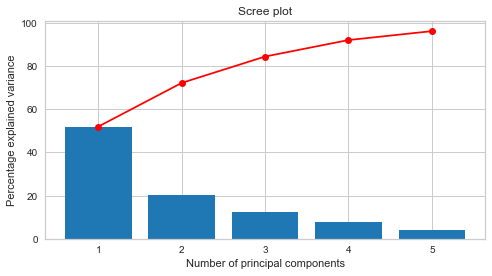

In [11]:
# scree plot pour la variance expliquée
# scree plot for explained variance
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.title("Scree plot")
    plt.savefig(fname='Cumsum_explained_variance_PCA.jpg', dpi=100, format='jpg', bbox_inches='tight')
    plt.show(block=False)
    
print('Cumulative summ of explained variance by num of principal components is: ' + str(pca.explained_variance_ratio_.cumsum()))
display_scree_plot(pca)

Optimal num of components seems to be 4, it will explain ~0.92% of variance

In [12]:
# séparer chaque PC comme une variable
# separate each PC as a variable
pc1 = pca.components_[0] 
pc2 = pca.components_[1]
pc3 = pca.components_[2]
pc4 = pca.components_[3]

In [13]:
# correlation circles function

#palette = sns.color_palette("bright", 10)

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    """Display correlation circles, one for each factorial plane"""

    # For each factorial plane
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # Initialise the matplotlib figure
            fig, ax = plt.subplots(figsize=(10,10))

            # Determine the limits of the chart
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Add arrows
            # If there are more than 30 arrows, we do not display the triangle at the end
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (see the doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # Display circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Define the limits of the chart
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Display grid lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlation Circle (PC{} and PC{})".format(d1+1, d2+1))
            plt.savefig(fname="Correlation_Circle_(PC{}_and_PC{}).jpg".format(d1+1, d2+1), dpi=100, format='jpg')
            plt.show(block=False)

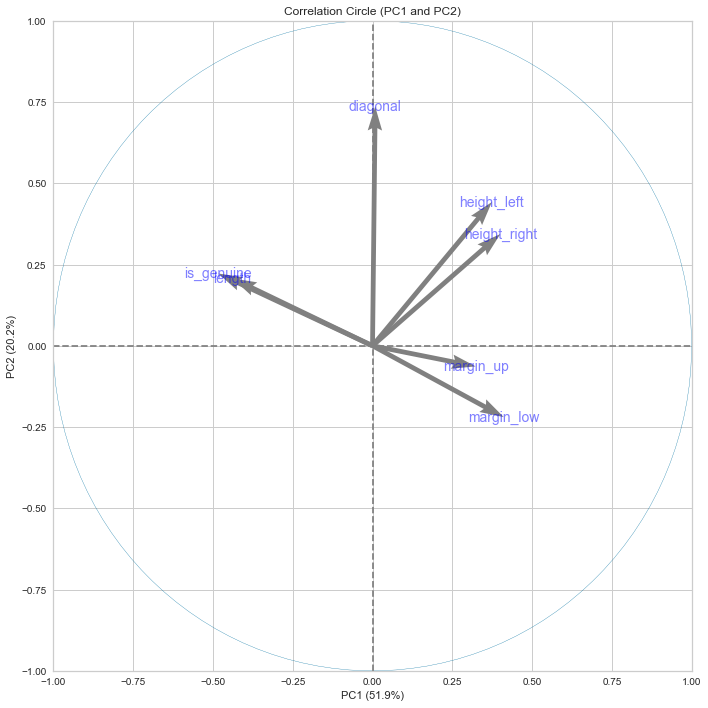

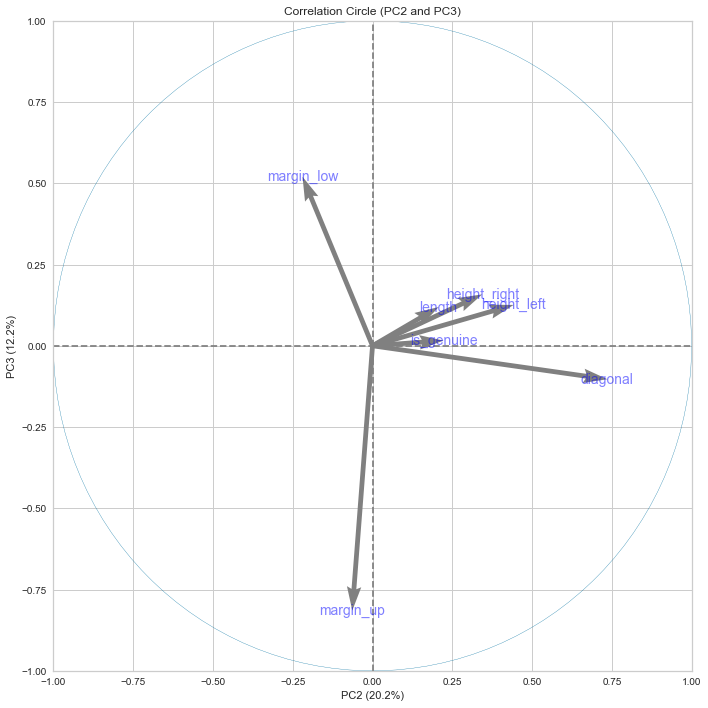

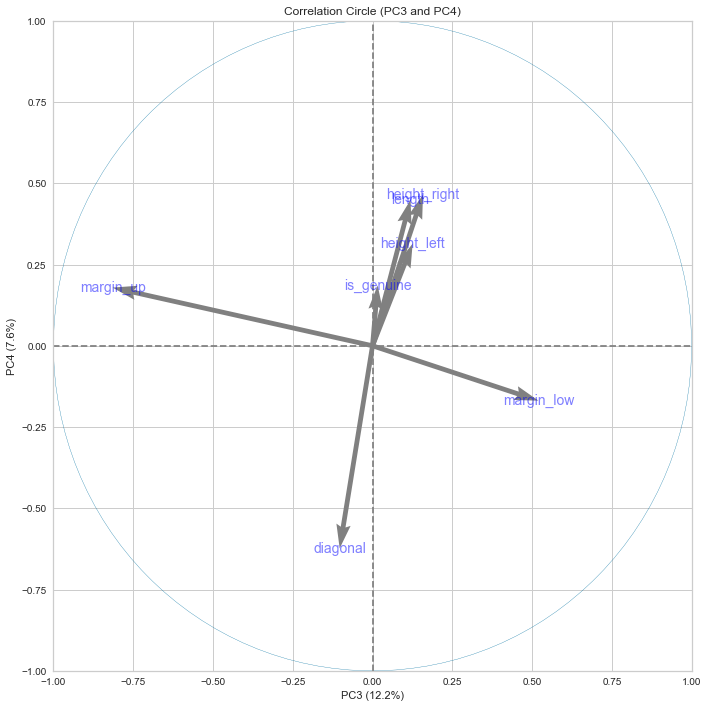

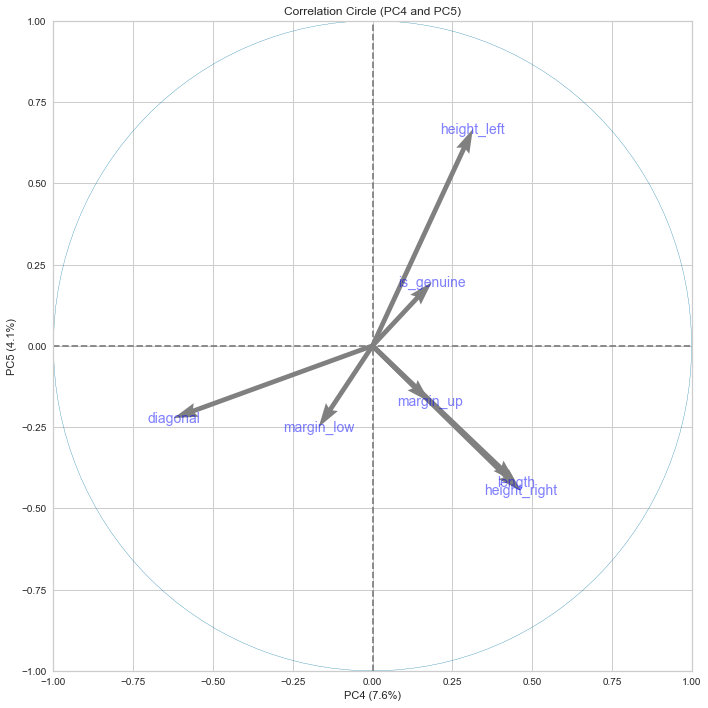

In [14]:
# Cercles de corrélation
# correlation circles
pcs = pca.components_

display_circles(pcs, num_components, pca, [(0,1)], labels=np.array(X.columns))
display_circles(pcs, num_components, pca, [(1,2)], labels=np.array(X.columns))
display_circles(pcs, num_components, pca, [(2,3)], labels=np.array(X.columns))
display_circles(pcs, num_components, pca, [(3,4)], labels=np.array(X.columns))

Summary for circles.
X axis represents 1st PC, Y represents 2nd PC.

Variables of length, is_genuine have medium negative correlation with PC1, while margin_up and margin_low have medium positive correlations with PC1.\
Diagonal variable has strong positive correlation with PC2.\
Height_left and height_right have medum positive correlation with both PC1 and PC2 (??? verify)

In [15]:
# individuals on a factorial plane function

def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.savefig(fname="Projection_of_points_(PC{}_and_PC{}).jpg".format(d1+1, d2+1), dpi=100, format='jpg')
            #plt.show()

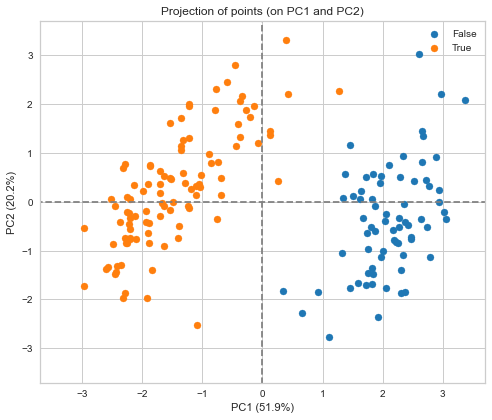

In [16]:
# Carte des facteurs individuels
# individuals factor map

# transformer les données originales mises à l'échelle dans un nouvel espace vectoriel et les visualiser
# transform original scaled data into new vector space and visualize it
X_projected = pca.transform(X_scaled)

display_factorial_planes(X_projected, num_components, pca,
                         [(0,1)], illustrative_var = X.is_genuine)

plt.savefig(fname='PCA_projection.jpg', dpi=100, format='jpg', bbox_inches='tight')

plt.show();

We can see that PCA clearly shows 2 distinct clusters of datapoints, separating real and fake banknotes.

### Task 2, Classification

Apply a classification algorithm and analyse the result obtained.

Visualise the partition obtained in the first factorial plane of the PCA and analyse it.

#### K-Means classification

Since we know that amount of clusters = 2, we bypass the step with optimal cluster number search.

In [17]:
# nos données
# our data
X = df.copy()

# standardiser
# standardize it
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

K-means model v1 (default parameters)

In [18]:
# Kmeans clustering model
kmeans = KMeans(init='random', n_clusters=2, n_init=10, max_iter=300)

# ajuster les données au modèle
# fit data to the model
kmeans.fit_predict(X_scaled)

# tracer chaque point de données à son cluster correspondant
# trace each datapoint to its corresponding cluster
clusters = kmeans.predict(X_scaled)

# ajouter le numéro de cluster aux données originales
# add cluster number to the original data
X_scaled_clustered = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_clustered['cluster'] = clusters

X_scaled_clustered['cluster'].value_counts()

1    99
0    71
Name: cluster, dtype: int64

K-means model v2 (custom parameters)

In [19]:
# Kmeans clustering model
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=30, max_iter=600)

# ajuster les données au modèle
# fit data to the model
kmeans.fit_predict(X_scaled)

# tracer chaque point de données à son cluster correspondant
# trace each datapoint to its corresponding cluster
clusters = kmeans.predict(X_scaled)

# ajouter le numéro de cluster aux données originales
# add cluster number to the original data
X_scaled_clustered = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_clustered['cluster'] = clusters

X_scaled_clustered['cluster'].value_counts()

1    99
0    71
Name: cluster, dtype: int64

As we can see, both K-means models result in one incorrectly flagged banknote (real one marked as fake)

In [20]:
# visualiser les clusters sur le premier plan factoriel
# visualize clusters on first factorial plane
pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)

X_reduced = pca.transform(X_scaled)

In [21]:
# convertir en dataframe
# convert into a dataframe
X_reduceddf = pd.DataFrame(X_reduced, index=X.index, columns=['PC1', 'PC2'])
X_reduceddf['cluster'] = clusters
X_reduceddf.head(3)

,PC1,PC2,cluster
0,1.268092,2.278191,0
1,-2.207379,-0.758887,1
2,-2.123955,-0.281632,1


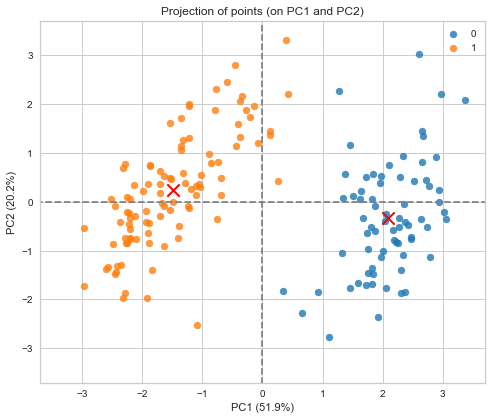

In [22]:
# visualiser les centres des clusters
# visualize cluster centers
centres_reduced = pca.transform(kmeans.cluster_centers_)

display_factorial_planes(X_reduced, 2, pca, [(0,1)],
                         illustrative_var = clusters, alpha=0.8)

plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1], marker='x',
            s=152, linewidth=2, color='red', zorder=10)

plt.savefig(fname='Kmeans_clusters_projection.jpg', dpi=100, format='jpg', bbox_inches='tight')

plt.show();

In [23]:
# function for visual representation of variables inside clusters

def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)    

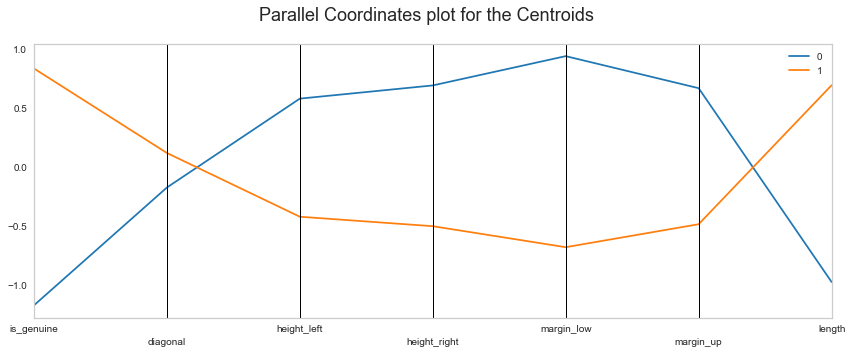

In [24]:
# interpréter la signification des clusters
# interpreting meaning of clusters
X_clustered = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_clustered['cluster'] = clusters

# Visualisation des caractéristiques de chaque groupe par la moyenne des variables.
# visualizing characteristics of each cluster by variable mean
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids['cluster'] = centroids.index

display_parallel_coordinates_centroids(centroids, 2)
plt.savefig(fname='Clusters_descriptions.jpg', dpi=100, format='jpg', bbox_inches='tight')
plt.show();

Conclusions:
    After applying K-means classification algorithm, we can see a clear separation between real and fake banknotes.\
    Same separation can be observed on individual variables level they represented by.\
    However K-means can't reach 100% accuracy (both parameters fail to attribute one real banknote as such).

### Task 3, Logistic regression (statsmodels logit)

In [25]:
# convertir les données bool en int pour la modélisation
# convert bool data to int for modelling
df.is_genuine = df.is_genuine.replace({True: 1, False: 0})
df.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.67,103.74,103.70,4.01,2.87,113.29
2,1,171.83,103.76,103.76,4.40,2.88,113.84


In [26]:
# construire un modèle
# build a model
result = smf.logit(formula = 'is_genuine ~ height_left + margin_low + length', data = df).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.025249
         Iterations 14


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_genuine   No. Observations:                  170
Model:                          Logit   Df Residuals:                      166
Method:                           MLE   Df Model:                            3
Date:                Mon, 07 Feb 2022   Pseudo R-squ.:                  0.9627
Time:                        11:27:58   Log-Likelihood:                -4.2923
converged:                       True   LL-Null:                       -115.17
Covariance Type:            nonrobust   LLR p-value:                 8.346e-48
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -918.1276    701.677     -1.308      0.191   -2293.388     457.133
height_left    -0.2207      5.054     -0.044      0.965     -10.126       9.685
margin_low    -13.2820      5.603     -2.371      0.018     -24.263      -2.301
length          8.9095      3.612      2.466      0.014       1.829      15.990
===============================================================================

Possibly complete quasi-separation: A fraction 0.76 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [27]:
# supprimer height_left de la formule en raison de la valeur p de 0,965
# remove height_left from formula due to p-value of 0.965
result = smf.logit(formula = 'is_genuine ~ margin_low + length', data = df).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.025254
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_genuine   No. Observations:                  170
Model:                          Logit   Df Residuals:                      167
Method:                           MLE   Df Model:                            2
Date:                Mon, 07 Feb 2022   Pseudo R-squ.:                  0.9627
Time:                        11:27:58   Log-Likelihood:                -4.2932
converged:                       True   LL-Null:                       -115.17
Covariance Type:            nonrobust   LLR p-value:                 6.999e-49
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -944.4190    377.481     -2.502      0.012   -1684.269    -204.569
margin_low   -13.3659      5.314     -2.515      0.012     -23.781      -2.950
length         8.9420      3.552      2.518      0.012       1.981      15.903
==============================================================================

Possibly complete quasi-separation: A fraction 0.76 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Pseudo R squared remains the same (0.9627);
LLR p-value is very small, much smaller than 0.05. It means that our model is better than a simple constant model

In [28]:
# confidence interval
result.conf_int()

,0,1
Intercept,-1684.268824,-204.569087
margin_low,-23.781369,-2.950419
length,1.980568,15.903455


In [29]:
# appliquer la fonction logistique aux valeurs prédites afin d'obtenir des probabilités
# apply logistic func to predicted values in order to get probabilities
def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

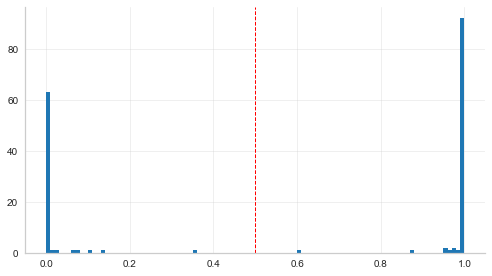

In [30]:
yhat = logistic(result.fittedvalues)

plt.hist(yhat, bins = 100, rwidth = 1);
plt.grid(alpha = 0.3)
plt.axvline(x= 0.5, c='red', lw = 1, linestyle = 'dashed')
sns.despine()
plt.savefig(fname='Logit_model_scores.jpg', dpi=100, format='jpg', bbox_inches='tight')

Model looks good at deciding where to put a specific banknote, genuine or fake class.

In [31]:
# predictions
yhat = result.predict(df[['margin_low', 'length']])

# score <0.5 est faux, >=0.5 est vrai
# score <0.5 is fake, >=0.5 is real
predicted_class = (yhat >= 0.5).astype(int)
predicted_class.value_counts()

1    100
0     70
dtype: int64

In [32]:
# confusion matrix
result.pred_table()

# true positive, false positive
# false negative, true negative

array([[69.,  1.],
       [ 1., 99.]])

Overall:
69 and 99 banknotes were correctly classified as fake and real
1 non fake banknote was classified as fake
1 fake banknote was classified as real

In [33]:
# la précision du modèle statsmodels
# accuracy of the model
accuracy = (69 + 99) / 170
print("Accuracy is {:.3f}".format(accuracy) + "%")

Accuracy is 0.988%


#### new input for statsmodel logit

In [34]:
# entrer de nouvelles données
# enter new data
new_data = pd.read_csv(f'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/example.csv')
new_data.head(3)

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3


In [35]:
nd_prediction = result.predict(new_data.iloc[:,:-1])

In [36]:
# func pour imprimer les résultats de la prédiction
# func to print out prediction results
def file_pred_results(prediction):
    for i in range(len(prediction)):
        if prediction[i] >=0.5:
            print('Banknote id ' + str(new_data.id[i]) + ' is REAL with probability of ' + str(logistic(nd_prediction)[i]) + ' %.')
        else:
            print('Banknote id ' + str(new_data.id[i]) + ' is FAKE with probability of ' + str(logistic(nd_prediction)[i]) + ' %.')

In [37]:
file_pred_results(nd_prediction)

Banknote id A_1 is FAKE with probability of 0.5000000049562694 %.
Banknote id A_2 is FAKE with probability of 0.5000000000514444 %.
Banknote id A_3 is FAKE with probability of 0.5000003586870496 %.
Banknote id A_4 is REAL with probability of 0.7310174532491766 %.
Banknote id A_5 is REAL with probability of 0.7310585769698161 %.


### Task 3, Logistic regression (sklearn)

In [38]:
# Données de formation
# training data
X = df.iloc[:, 1:]

# données à prédire
# data to predict
y = df['is_genuine']

# diviser les données en train et test
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# créer un modèle
# create a model
model = LogisticRegression(solver='lbfgs', max_iter=199)

# ajuster le modèle sur les données
# fit model on data
model.fit(X_train, y_train)

LogisticRegression(max_iter=199)

In [39]:
# faire des prédictions en utilisant notre modèle (classe)
# make predictions using our model (class)
yhat = model.predict(X_test)

# faire des prédictions en utilisant notre modèle (probabilité)
# make predictions using our model (probability)
yhat2 = model.predict_proba(X_test)

In [40]:
# la précision du modèle sklearn
# evaluate predictions via scores
acc = accuracy_score(y_test, yhat)
print("Accuracy is {:.3f}".format(acc) + "%")

Accuracy is 0.982%


#### new input for sklearn model

In [41]:
# entrer de nouvelles données
# enter new data
new_data = pd.read_csv(f'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/example.csv')
new_data.head(3)

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3


In [42]:
# prédictions sur les nouvelles données
# predictions on the new data
nd_pred_class = model.predict(new_data.iloc[:,:-1])
nd_pred_proba = model.predict_proba(new_data.iloc[:,:-1])

In [43]:
# func pour imprimer les résultats de la prédiction
# func to print out prediction results
def file_pred_results(prediction):
    for i in range(len(prediction)):
        if prediction[i] >=0.5:
            print('Banknote id ' + str(new_data.id[i]) + ' is REAL with probability ' + str(max((nd_pred_proba)[i])) + ' %.')
        else:
            print('Banknote id ' + str(new_data.id[i]) + ' is FAKE with probability ' + str(max((nd_pred_proba)[i])) + ' %.')

In [44]:
file_pred_results(nd_pred_class)

Banknote id A_1 is FAKE with probability 0.9714141151831927 %.
Banknote id A_2 is FAKE with probability 0.9866265290303662 %.
Banknote id A_3 is FAKE with probability 0.9716235440178718 %.
Banknote id A_4 is REAL with probability 0.8901433089027112 %.
Banknote id A_5 is REAL with probability 0.9904423766337491 %.


### Prediction functions

In [45]:
# prédire en utilisant les modèles statistiques logit
# predict using statsmodels logit
def predict_logit():
    my_file = input('Please enter CSV filename from your working directory to predict:')
    x = pd.read_csv(f'./{my_file}.csv')
    nd_prediction = result.predict(x.iloc[:,:-1])
    for i in range(len(nd_prediction)):
        if nd_prediction[i] >=0.5:
            print('Banknote id ' + str(x.id[i]) + ' is REAL with probability of ' + str(logistic(nd_prediction)[i]) + ' %.')
        else:
            print('Banknote id ' + str(x.id[i]) + ' is FAKE with probability of ' + str(logistic(nd_prediction)[i]) + ' %.')

In [46]:
# prédire en utilisant la régression logistique de sklearn
# predict using sklearn logistic regression
def predict_sklearn():
    my_file = input('Please enter CSV filename from your working directory to predict:')
    x = pd.read_csv(f'./{my_file}.csv')
    nd_pred_class = model.predict(x.iloc[:,:-1])
    nd_pred_proba = model.predict_proba(x.iloc[:,:-1])
    for i in range(len(nd_pred_class)):
        if nd_pred_class[i] >=0.5:
            print('Banknote id ' + str(x.id[i]) + ' is REAL with probability ' + str(max((nd_pred_proba)[i])) + ' %.')
        else:
            print('Banknote id ' + str(x.id[i]) + ' is FAKE with probability ' + str(max((nd_pred_proba)[i])) + ' %.')

In [53]:
predict_logit()

Please enter CSV filename from your working directory to predict: example


Banknote id A_1 is FAKE with probability of 0.5000000049562694 %.
Banknote id A_2 is FAKE with probability of 0.5000000000514444 %.
Banknote id A_3 is FAKE with probability of 0.5000003586870496 %.
Banknote id A_4 is REAL with probability of 0.7310174532491766 %.
Banknote id A_5 is REAL with probability of 0.7310585769698161 %.


In [54]:
predict_sklearn()

Please enter CSV filename from your working directory to predict: example


Banknote id A_1 is FAKE with probability 0.9714141151831927 %.
Banknote id A_2 is FAKE with probability 0.9866265290303662 %.
Banknote id A_3 is FAKE with probability 0.9716235440178718 %.
Banknote id A_4 is REAL with probability 0.8901433089027112 %.
Banknote id A_5 is REAL with probability 0.9904423766337491 %.
